### Binary Classification Model for In-Vehicle Coupon Recommendation Using XGBoost
### David Lowe
### December 13, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The In-Vehicle Coupon Recommendation dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: This dataset, available from UC Irvine's Machine Learning Repository, studies whether a person will accept the coupon recommended to him under different driving scenarios.

ANALYSIS: The performance of the preliminary XGBoost model achieved an accuracy benchmark of 0.7547. After a series of tuning trials, the refined XGBoost model processed the training dataset with a final accuracy score of 0.7619. When we applied the last model to the test dataset, the model achieved an accuracy score of 0.7737.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: In-Vehicle Coupon Recommendation Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://archive-beta.ics.uci.edu/ml/datasets/in+vehicle+coupon+recommendation

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5

# Set various default modeling parameters
SCORING_METRIC = 'accuracy'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/ucirvine-in-vehicle-coupon-recommendation/in-vehicle-coupon-recommendation.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

       destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  ...  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1           Coffee House         2h  Female  21  Unmarried partner  ...   
2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3           Coffee House         2h  Female  21  Unmarried partner  ...   
4           Coffee House         1d  Female  21  Unmarried partner  ...   

   CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0        never       NaN                  4~8              1~3   
1        never       NaN                  4~8           

In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [12]:
print(df_dataset_import.describe())

        temperature  has_children  toCoupon_GEQ5min  toCoupon_GEQ15min  \
count  12684.000000  12684.000000           12684.0       12684.000000   
mean      63.301798      0.414144               1.0           0.561495   
std       19.154486      0.492593               0.0           0.496224   
min       30.000000      0.000000               1.0           0.000000   
25%       55.000000      0.000000               1.0           0.000000   
50%       80.000000      0.000000               1.0           1.000000   
75%       80.000000      1.000000               1.0           1.000000   
max       80.000000      1.000000               1.0           1.000000   

       toCoupon_GEQ25min  direction_same  direction_opp             Y  
count       12684.000000    12684.000000   12684.000000  12684.000000  
mean            0.119126        0.214759       0.785241      0.568433  
std             0.323950        0.410671       0.410671      0.495314  
min             0.000000        0.000000     

In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64
Total number of NaN in the dataframe:  13370


### 1.d) Data Cleaning

In [14]:
# Dropping features that have too many NA's or have no variation
df_dataset_import.drop(columns=['car','toCoupon_GEQ5min','direction_opp'], inplace=True)

# Convert columns from one data type to another
df_dataset_import['temperature'] = df_dataset_import['temperature'].astype('category')
# df_dataset_import['destination'] = df_dataset_import['destination'].astype('category')
# df_dataset_import['passanger'] = df_dataset_import['passanger'].astype('category')
# df_dataset_import['weather'] = df_dataset_import['weather'].astype('category')
# df_dataset_import['time'] = df_dataset_import['time'].astype('category')
# df_dataset_import['coupon'] = df_dataset_import['coupon'].astype('category')
# df_dataset_import['expiration'] = df_dataset_import['expiration'].astype('category')
# df_dataset_import['gender'] = df_dataset_import['gender'].astype('category')
# df_dataset_import['age'] = df_dataset_import['age'].astype('category')
# df_dataset_import['maritalStatus'] = df_dataset_import['maritalStatus'].astype('category')
# df_dataset_import['education'] = df_dataset_import['education'].astype('category')
# df_dataset_import['occupation'] = df_dataset_import['occupation'].astype('category')
# df_dataset_import['income'] = df_dataset_import['income'].astype('category')
# df_dataset_import['Bar'] = df_dataset_import['Bar'].astype('category')
# df_dataset_import['CoffeeHouse'] = df_dataset_import['CoffeeHouse'].astype('category')
# df_dataset_import['CarryAway'] = df_dataset_import['CarryAway'].astype('category')
# df_dataset_import['RestaurantLessThan20'] = df_dataset_import['RestaurantLessThan20'].astype('category')
# df_dataset_import['Restaurant20To50'] = df_dataset_import['Restaurant20To50'].astype('category')

# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'Y':'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

       destination  passanger weather temperature  time  \
0  No Urgent Place      Alone   Sunny          55   2PM   
1  No Urgent Place  Friend(s)   Sunny          80  10AM   
2  No Urgent Place  Friend(s)   Sunny          80  10AM   
3  No Urgent Place  Friend(s)   Sunny          80   2PM   
4  No Urgent Place  Friend(s)   Sunny          80   2PM   

                  coupon expiration  gender age      maritalStatus  ...  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1           Coffee House         2h  Female  21  Unmarried partner  ...   
2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3           Coffee House         2h  Female  21  Unmarried partner  ...   
4           Coffee House         1d  Female  21  Unmarried partner  ...   

            income    Bar CoffeeHouse CarryAway RestaurantLessThan20  \
0  $37500 - $49999  never       never       NaN                  4~8   
1  $37500 - $49999  never       never       NaN   

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   destination           12684 non-null  object  
 1   passanger             12684 non-null  object  
 2   weather               12684 non-null  object  
 3   temperature           12684 non-null  category
 4   time                  12684 non-null  object  
 5   coupon                12684 non-null  object  
 6   expiration            12684 non-null  object  
 7   gender                12684 non-null  object  
 8   age                   12684 non-null  object  
 9   maritalStatus         12684 non-null  object  
 10  has_children          12684 non-null  int64   
 11  education             12684 non-null  object  
 12  occupation            12684 non-null  object  
 13  income                12684 non-null  object  
 14  Bar                   12577 non-null  object  
 15  Co

In [16]:
print(df_dataset_import.describe())

       has_children  toCoupon_GEQ15min  toCoupon_GEQ25min  direction_same  \
count  12684.000000       12684.000000       12684.000000    12684.000000   
mean       0.414144           0.561495           0.119126        0.214759   
std        0.492593           0.496224           0.323950        0.410671   
min        0.000000           0.000000           0.000000        0.000000   
25%        0.000000           0.000000           0.000000        0.000000   
50%        0.000000           1.000000           0.000000        0.000000   
75%        1.000000           1.000000           0.000000        0.000000   
max        1.000000           1.000000           1.000000        1.000000   

             target  
count  12684.000000  
mean       0.568433  
std        0.495314  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        1.000000  
max        1.000000  


In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

destination               0
passanger                 0
weather                   0
temperature               0
time                      0
coupon                    0
expiration                0
gender                    0
age                       0
maritalStatus             0
has_children              0
education                 0
occupation                0
income                    0
Bar                     107
CoffeeHouse             217
CarryAway               151
RestaurantLessThan20    130
Restaurant20To50        189
toCoupon_GEQ15min         0
toCoupon_GEQ25min         0
direction_same            0
target                    0
dtype: int64
Total number of NaN in the dataframe:  794


### 1.e) Splitting Data into Sets

In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (12684, 23) df_features_import.shape: (12684, 22) df_target_import.shape: (12684,)


In [20]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (10147, 22) df_target_train.shape: (10147,)
df_features_test.shape: (2537, 22) df_target_test.shape: (2537,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

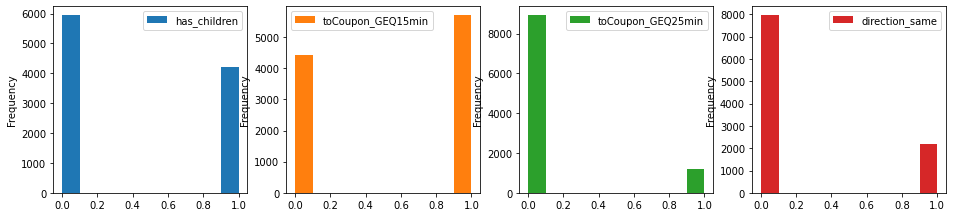

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

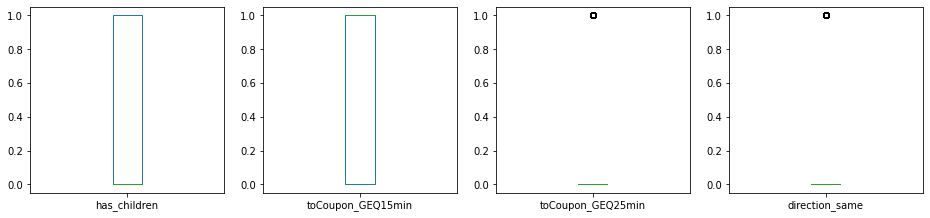

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

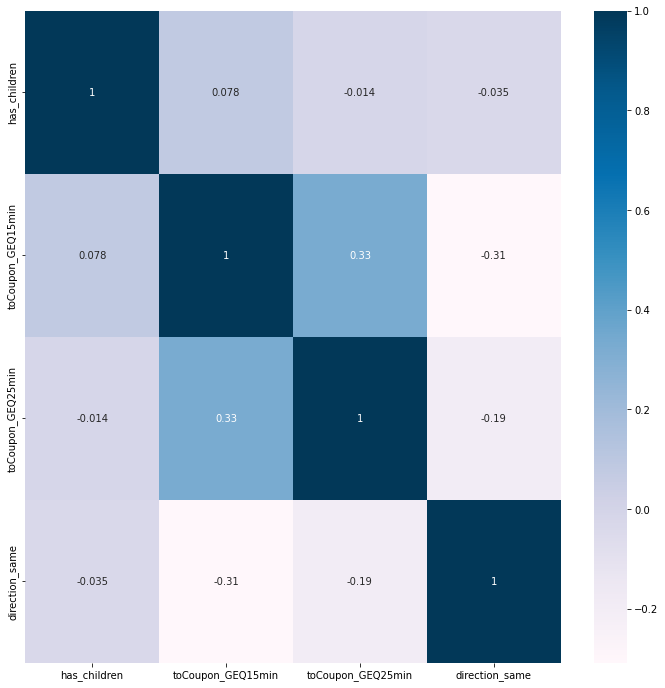

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(12, 12))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    # ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 4
Number of categorical columns: 18
Total number of columns in the feature dataframe: 22


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (10147, 22) to array_features_train.shape: (10147, 114)


### 3.b) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (10147, 114) array_target_train.shape: (10147,)


In [34]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [36]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
# train_models = [('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', tree_method='gpu_hist'))]
train_models = [('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'))]

In [37]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


XGB: 0.754705 (0.003714)
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='logloss', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=2, num_parallel_tree=None,
              predictor=None, random_state=888, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)
Model training time: 0:00:31.774855 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   31.6s finished


### 4.b) Algorithm Tuning

In [38]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [39]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100, 501, 100),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([1, 2, 3]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best: 0.760323 using {'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 400}
0.737756 (0.002871) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.747315 (0.003936) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.750763 (0.003612) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.754213 (0.003121) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
0.749580 (0.004282) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.736376 (0.004341) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
0.746033 (0.004406) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
0.749679 (0.004760) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}
0.753226 (0.008002) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 400}
0.752438 (0.005785) with: {'max_depth': 3, 'min_child_weight': 2, 'n_esti

In [40]:
BEST_N_ESTIMATORS = 400
BEST_MAX_DEPTH = 9
BEST_MIN_CHILD_WEIGHT = 1

In [41]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]), colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best: 0.761998 using {'colsample_bytree': 0.9, 'subsample': 0.9}
0.752735 (0.005849) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.752734 (0.006021) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.759041 (0.007263) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.760224 (0.008644) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.753622 (0.006811) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.754016 (0.005586) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.758154 (0.005276) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.756577 (0.006772) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.754805 (0.004313) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.756972 (0.005460) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.761998 (0.005863) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.758154 (0.009231) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.754312 (0.007693) with: {'colsam

In [42]:
BEST_COLSAMPLE_BYTREE = 0.9
BEST_SUBSAMPLE = 0.9

### 4.c) Compare Algorithms After Tuning

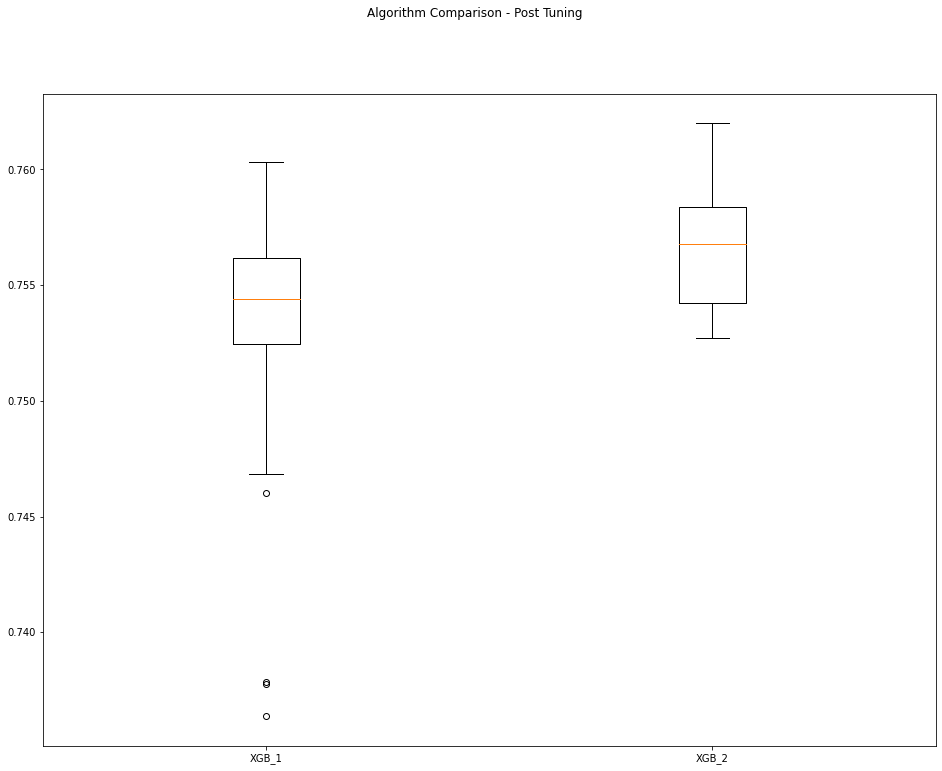

In [43]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [44]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [45]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [46]:
final_model = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            colsample_bytree=BEST_COLSAMPLE_BYTREE, subsample=BEST_SUBSAMPLE,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
final_model.fit(array_features_train, array_target_train)
print(final_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=2, num_parallel_tree=1, predictor='auto',
              random_state=888, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


### 6.b) Load Test Dataset and Make Predictions

In [47]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
array_target_test = df_target_test.ravel()
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (2537, 114) array_target_test.shape: (2537,)


In [48]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[1 0 0 ... 0 0 1]


In [49]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(array_target_test, test_predictions))
print(confusion_matrix(array_target_test, test_predictions))
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.7737485218762318
ROC/AUC Score: 0.765854440343377
[[ 778  325]
 [ 249 1185]]
              precision    recall  f1-score   support

           0       0.76      0.71      0.73      1103
           1       0.78      0.83      0.81      1434

    accuracy                           0.77      2537
   macro avg       0.77      0.77      0.77      2537
weighted avg       0.77      0.77      0.77      2537



In [50]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [51]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 1:33:59.555756
